incenter.ipynb

In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import norm, inv
from scipy.linalg import null_space
from scipy.stats import beta

def check_A_int(A_int):
    # Stub: always valid
    return True, ""

def vertices_unit_ball(A_int):
    """
    Compute S vertices of the feasibility domain intersecting the unit ball.
    Returns a DataFrame with columns:
      N_1...N_S, r_1...r_S, vertex_ID
    """
    A_int = np.asarray(A_int)
    S = A_int.shape[0]
    rows = []
    for i in range(S):
        # unit-normalized intrinsic growth direction
        sup = -A_int[:, i]
        sup = sup / norm(sup)
        # densities: only species i is present at 1
        N = np.zeros(S); N[i] = 1.0
        row = {f'N_{j+1}': N[j] for j in range(S)}
        row.update({f'r_{j+1}': sup[j] for j in range(S)})
        row['vertex_ID'] = f'vertex {i+1}'
        rows.append(row)
    return pd.DataFrame(rows)

def cone_vertices_director_vertices(A_int):
    """
    From vertices_unit_ball, compute the facet normals (director vectors).
    Returns a DataFrame with columns:
      r_1...r_S, dir_vec_1...dir_vec_S
    """
    df = vertices_unit_ball(A_int)
    S = A_int.shape[0]
    r_cols   = [f'r_{i+1}' for i in range(S)]
    r_mat    = df[r_cols].values
    dir_vecs = []
    for i in range(S):
        others = np.delete(r_mat, i, axis=0)
        ns = null_space(others)
        v  = ns[:, 0] / norm(ns[:, 0])
        dir_vecs.append(v)
    dir_df = pd.DataFrame(dir_vecs, columns=[f'dir_vec_{i+1}' for i in range(S)])
    return pd.concat([df[r_cols], dir_df], axis=1)

def incenter_inradius_isoprob_calculation(A_int):
    """
    Compute:
      I     (incenter, unit-normalized),
      theta (cap radius),
      Xi    (cap area)
    """

    # Normalizar columnas de A para que estén en la esfera unitaria
    column_norms = np.linalg.norm(A_int, axis=0)
    if np.any(column_norms == 0):
        raise ValueError("Algunas columnas de A tienen norma cero, no se pueden normalizar.")
    A_int = A_int / column_norms

    curves = cone_vertices_director_vertices(A_int)
    S = A_int.shape[0]
    r_cols   = [f'r_{i+1}' for i in range(S)]
    dir_cols = [f'dir_vec_{i+1}' for i in range(S)]
    dir_mat  = curves[dir_cols].values
    correction = []
    for _, row in curves.iterrows():
        v = row[r_cols].values
        dots = dir_mat.dot(v)
        correction.append(1 if np.all(np.round(dots, 12) >= 0) else -1)
    I_aux     = inv(dir_mat).dot(np.array(correction).reshape(S, 1)).flatten()
    sin_theta = np.sqrt(1.0 / np.dot(I_aux, I_aux))
    I_unit    = I_aux * sin_theta
    I         = I_unit / norm(I_unit)
    theta     = np.arcsin(sin_theta)
    a_par     = 0.5 * (S - 1)
    b_par     = 0.5
    Xi        = 0.5 * beta.cdf(sin_theta**2, a_par, b_par)
    return I, theta, Xi

# Example
A_int = np.diag([-1,-1,-1]) #+ 0.1
vertices_df = vertices_unit_ball(A_int)
cone_df     = cone_vertices_director_vertices(A_int)
I, theta, Xi = incenter_inradius_isoprob_calculation(A_int)


print("Incenter I:", I)
print("Theta (rad):", theta)

Incenter I: [0.57735027 0.57735027 0.57735027]
Theta (rad): 0.6154797086703873


Size of the feasability zone

In [ ]:
import numpy as np
from numpy.linalg import inv, cholesky, LinAlgError
from joblib import Parallel, delayed
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

def omega_bootstrap(A, replicates=1000, samples_per_replicate=10000,
                    use_chol_decomp=False, n_jobs=-1, seed=None):
    """
    Estima Omega(A): proporción de vectores factibles dentro de la esfera unitaria.
    Usa muestreo Monte Carlo desde N(0, Σ) y evalúa cuántos caen en el ortante positivo.

    Parameters:
        A : np.ndarray
            Matriz de interacciones (SxS)
        replicates : int
            Número de estimaciones independientes
        samples_per_replicate : int
            Número de muestras por estimación
        use_chol_decomp : bool
            Si True, usa Cholesky para invertir AᵀA
        n_jobs : int
            Número de procesos paralelos para usar
        seed : int or None
            Semilla para reproducibilidad

    Returns:
        np.ndarray
            Estimaciones de Omega (longitud = replicates)
    """
    A = np.array(A)
    S = A.shape[0]

    if A.shape[1] != S:
        raise ValueError("La matriz A debe ser cuadrada (SxS)")

    # Normalizar columnas de A para que estén en la esfera unitaria
    column_norms = np.linalg.norm(A, axis=0)
    if np.any(column_norms == 0):
        raise ValueError("Algunas columnas de A tienen norma cero, no se pueden normalizar.")
    A = A / column_norms
    
    try:
        AtA = A.T @ A
        if use_chol_decomp:
            L = cholesky(AtA)
            Sigma = inv(L.T) @ inv(L)
        else:
            Sigma = inv(AtA)
    except LinAlgError:
        raise ValueError("No se pudo invertir AᵀA. Puede no ser positiva definida.")

    if seed is not None:
        np.random.seed(seed)

    # Factor de descomposición para muestreo
    L = cholesky(Sigma)

    def estimate():
        Z = np.random.randn(samples_per_replicate, S)  # muestras estándar
        X = Z @ L.T  # transformación para obtener covarianza Σ
        is_positive = (X > 0).all(axis=1)
        return np.mean(is_positive)

    results = Parallel(n_jobs=n_jobs)(delayed(estimate)() for _ in range(replicates))

    return np.array(results)





def calculateC(name):
    A = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_A.csv').to_numpy()[:,1:].astype(np.float64)
    B = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_B.csv').to_numpy()[:,1:].astype(np.float64)
    P = pd.read_csv('complexity72h-2025-main/data/'+name+'/env.csv')
    P = P.drop(columns=['Unnamed: 0'], errors='ignore').to_numpy()

    C = np.zeros((A.shape[0], A.shape[1], len(P)))
    for i,p in enumerate(P):
        C[:,:,i] = A + B*p[0]

    # Normalizar columnas de A para que estén en la esfera unitaria
    column_norms = np.linalg.norm(C, axis=0)
    if np.any(column_norms == 0):
        raise ValueError("Algunas columnas de A tienen norma cero, no se pueden normalizar.")
    Cren = C / column_norms

    return -Cren


def species_vector_to_incenter(C, name, species_number):
    temporal = C.shape[-1]
    C2 = np.zeros(C.shape)
    for t in range(temporal):
        r_incenter, theta, Xi = incenter_inradius_isoprob_calculation(C[:,:,t])
        vectors = np.hsplit(C[:,:,t], C[:,:,t].shape[1])    
        vectors[species_number] = -r_incenter
        C2[:,:,t] = np.column_stack(vectors)
    return C2 

def calculate_prob_ext(C, name, species_number):
    temporal = C.shape[-1]
    Omegas = np.zeros((temporal))
    Omegas_S = np.zeros((temporal))
    prob_ext = np.zeros((temporal))
    C2 = species_vector_to_incenter(C, name,species_number)
    for t in range(temporal):
        Omegas[t] = np.mean(omega_bootstrap(C[:,:,t], replicates=1000, samples_per_replicate=10000, seed=42))
        Omegas_S[t] = np.mean(omega_bootstrap(C2[:,:,t], replicates=1000, samples_per_replicate=10000, seed=42))
        prob_ext[t] = Omegas_S[t]/Omegas[t]

    return prob_ext 


In [ ]:
def plot_prob_ext(name):
    species_names = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_A.csv').to_numpy()[:,:1][:,0]
    C = calculateC(name)
    PiE = dict()
    temporal = C.shape[-1]
    for species_number, name in enumerate(species_names):
        PiE[species_number] = calculate_prob_ext(C, name,species_number)
        plt.plot(range(len(PiE[species_number])), PiE[species_number], label = name)

    plt.title(name)
    plt.plot(range(temporal), [1/len(species_names) for _ in range(temporal)],':',color = 'black', label = 'Symmetric FD')
    plt.xlabel('Years',fontsize=15)
    plt.ylabel('$P_i^E(A)$',fontsize=15)
    plt.legend()
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)


$P_i^E(A)$

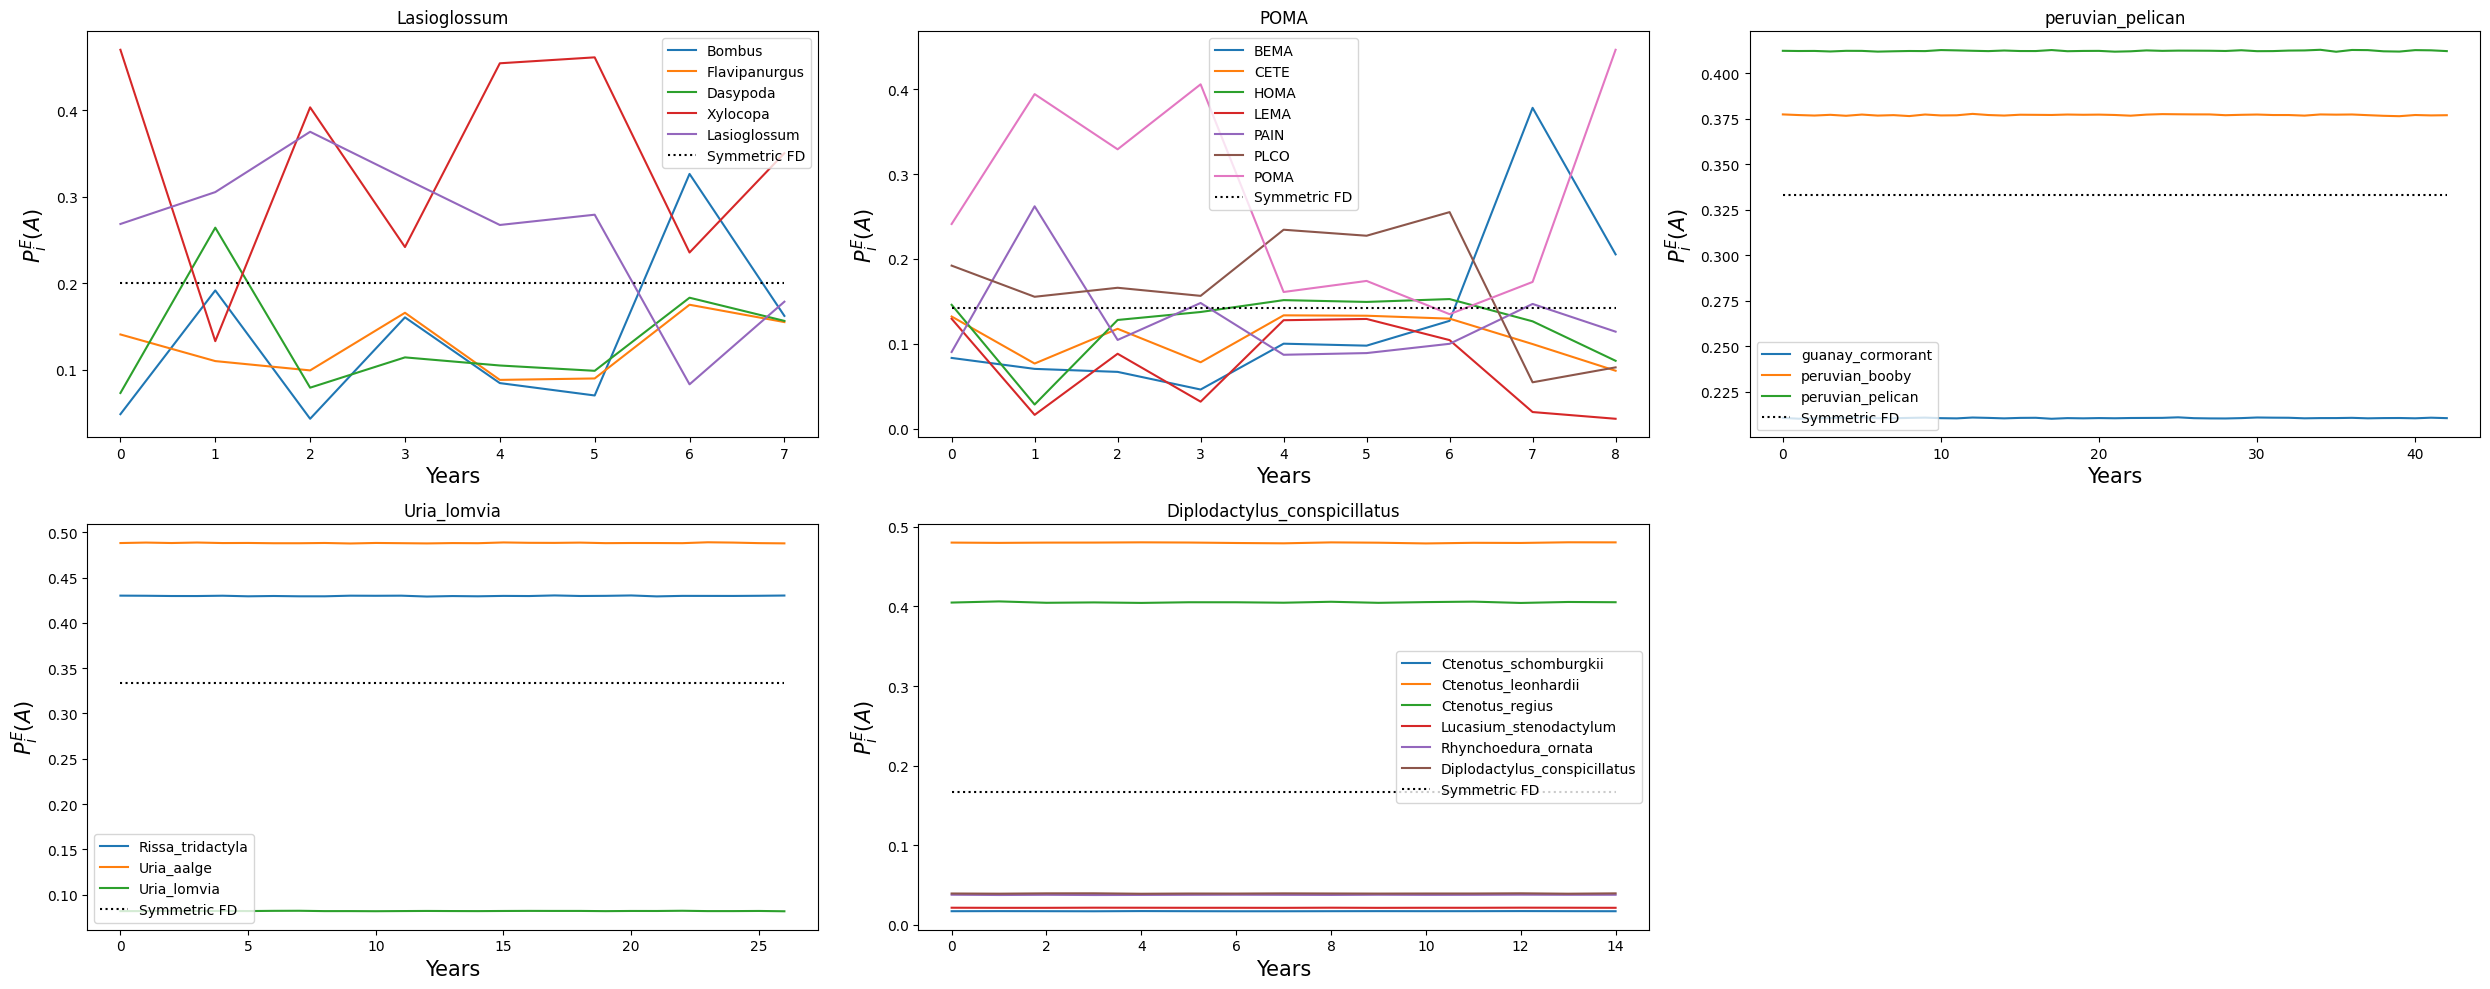

In [4]:


plt.figure(figsize=(25,10))

plt.subplot(2,3,1)
plot_prob_ext('BEEFUN')

plt.subplot(2,3,2)
plot_prob_ext('CARACOLES')

plt.subplot(2,3,3)
plot_prob_ext('DIG_13')


plt.subplot(2,3,4)
plot_prob_ext('DIG_50')

plt.subplot(2,3,5)
plot_prob_ext('LPI_2858')


plt.tight_layout()
plt.show()

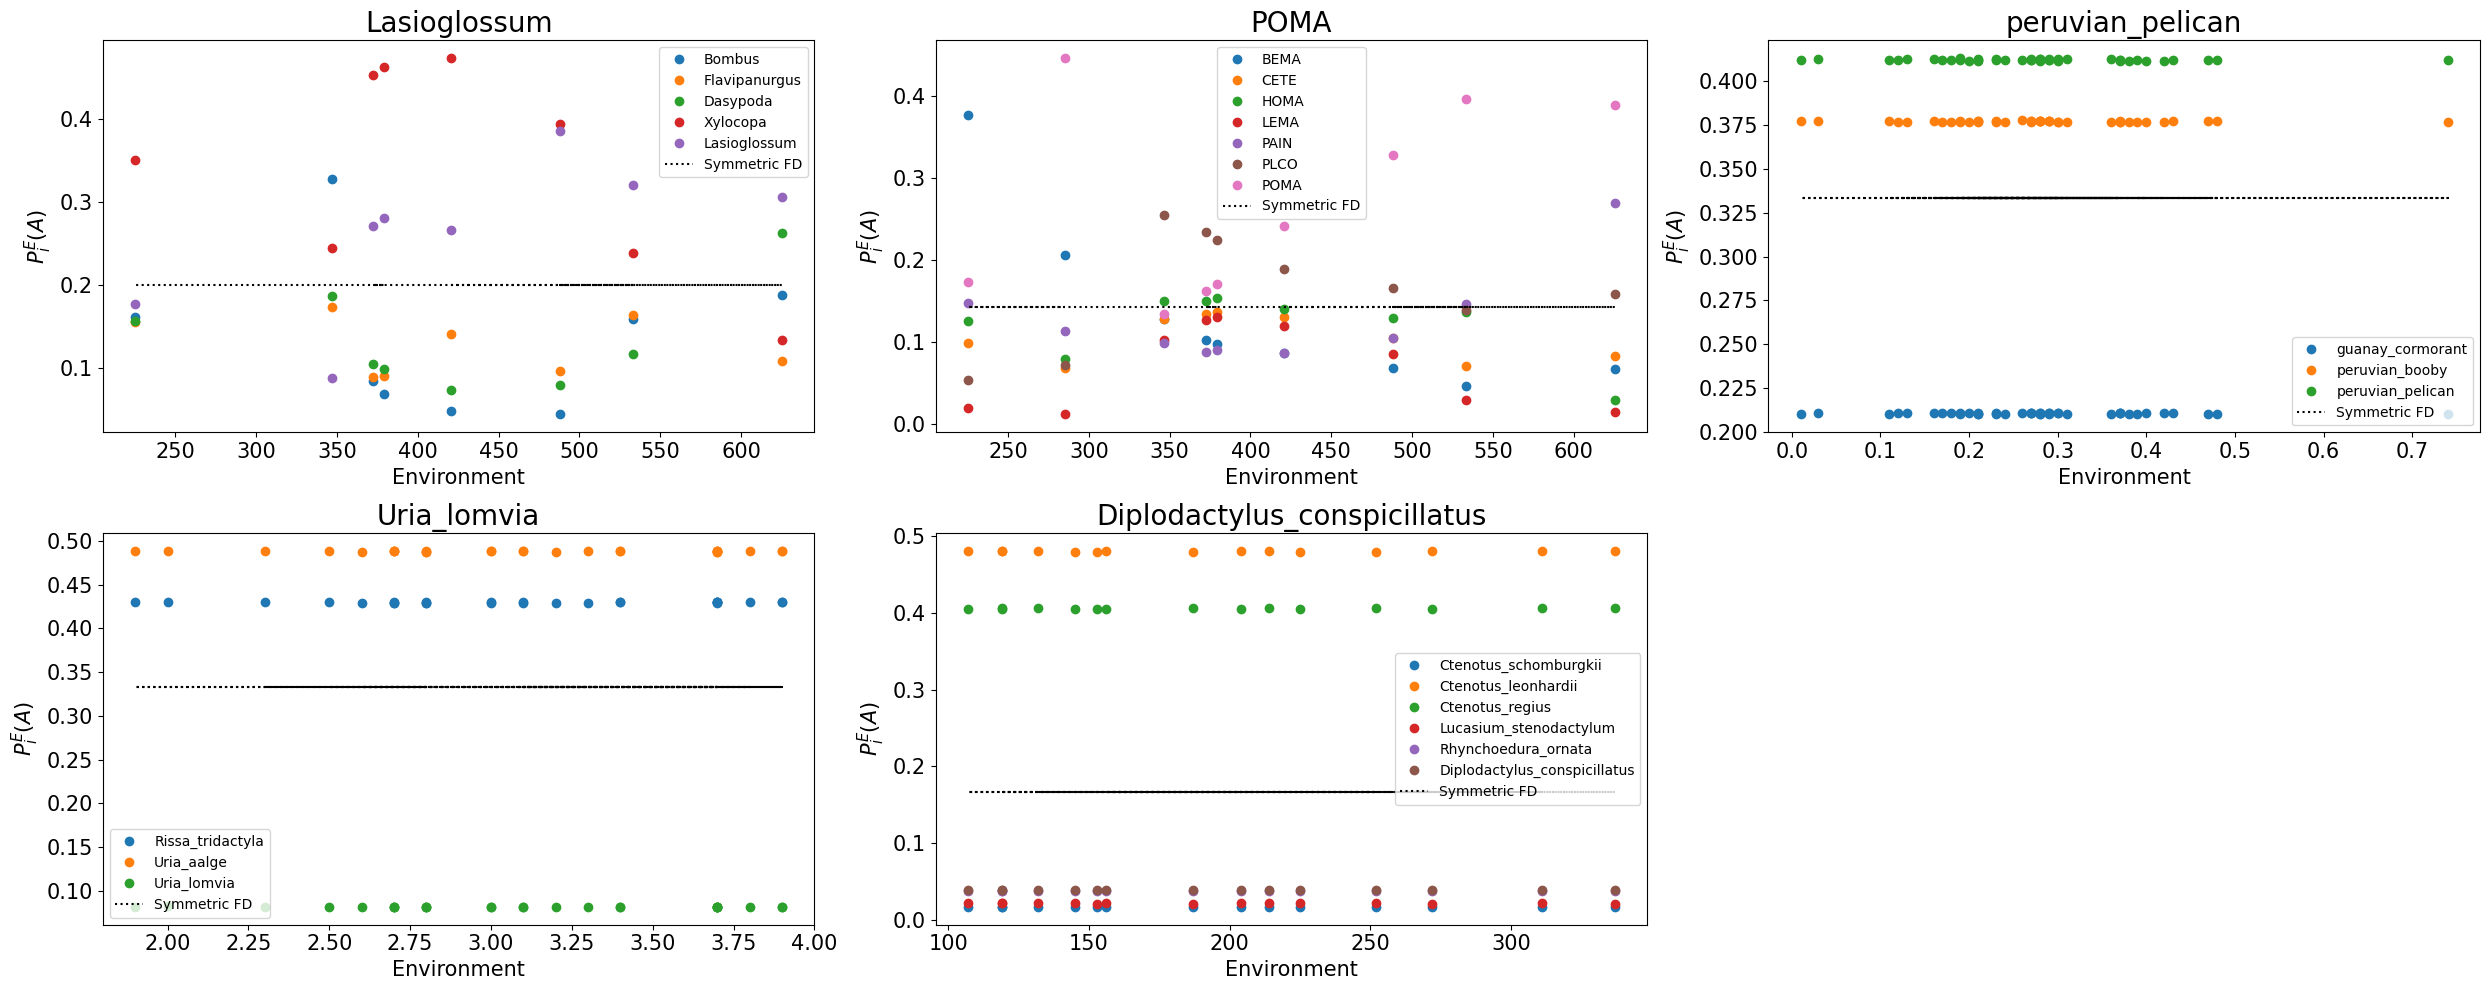

In [5]:
def giveP(name):
    P = pd.read_csv('complexity72h-2025-main/data/'+name+'/env.csv')
    P = P.drop(columns=['Unnamed: 0'], errors='ignore').to_numpy()
    return P.transpose()[0]


def plot_prob_ext_env(name):
    species_names = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_A.csv').to_numpy()[:,:1][:,0]
    env_range = giveP(name)
    C = calculateC(name)
    PiE = dict()
    temporal = C.shape[-1]
    for species_number, name in enumerate(species_names):
        PiE[species_number] = calculate_prob_ext(C, name,species_number)
        plt.plot(env_range, PiE[species_number], 'o',label = name)

    plt.plot(env_range, [1/len(species_names) for _ in range(temporal)],':',color = 'black', label = 'Symmetric FD')
    plt.xlabel('Environment',fontsize=15)
    plt.ylabel('$P_i^E(A)$',fontsize=15)
    plt.legend()
    plt.title(name,fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)



plt.figure(figsize=(25,10))

plt.subplot(2,3,1)
plot_prob_ext_env('BEEFUN')

plt.subplot(2,3,2)
plot_prob_ext_env('CARACOLES')

plt.subplot(2,3,3)
plot_prob_ext_env('DIG_13')

plt.subplot(2,3,4)
plot_prob_ext_env('DIG_50')

plt.subplot(2,3,5)
plot_prob_ext_env('LPI_2858')

plt.tight_layout()
plt.show()

$\Omega$

In [ ]:
def calculate_Omega_S(C, name, species_number):
    temporal = C.shape[-1]
    Omegas = np.zeros((temporal))
    Omegas_S = np.zeros((temporal))
    prob_ext = np.zeros((temporal))
    C2 = species_vector_to_incenter(C, name,species_number)
    for t in range(temporal):
        # Omegas[t] = np.mean(omega_bootstrap(C[:,:,t], replicates=1000, samples_per_replicate=10000, seed=42))
        Omegas_S[t] = np.mean(omega_bootstrap(C2[:,:,t], replicates=1000, samples_per_replicate=10000, seed=42))
        # prob_ext[t] = Omegas_S[t]/Omegas[t]

    return Omegas_S 

def plot_Omega_S_regions(name):
    species_names = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_A.csv').to_numpy()[:,:1][:,0]
    C = calculateC(name)
    PiE = dict()
    temporal = C.shape[-1]
    for species_number, name_s in enumerate(species_names):
        PiE[species_number] = calculate_Omega_S(C, name,species_number)

    df = pd.DataFrame({name_s: PiE[i] for i, name_s in enumerate(species_names)})
    ax = df.plot.area(stacked=True, figsize=(12, 6))
    plt.title(name)
    plt.xlabel('Years', fontsize=15)
    plt.ylabel('$\Omega_S$', fontsize=15)
    plt.legend()



def calculate_Omega(C):
    temporal = C.shape[-1]
    Omegas = np.zeros((temporal))
    for t in range(temporal):
        Omegas[t] = np.mean(omega_bootstrap(C[:,:,t], replicates=1000, samples_per_replicate=10000, seed=42))

    return Omegas 

def plot_Omega(name):
    species_names = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_A.csv').to_numpy()[:,:1][:,0]
    
    C = calculateC(name)
    PiE = dict()
    temporal = C.shape[-1]
    PiE = calculate_Omega(C)
    plt.plot(range(len(PiE)), PiE,'-', color = 'black', label = 'Omega')
    plt.xlabel('Years',fontsize=15)
    plt.ylabel('$\Omega_S$',fontsize=15)
    plt.legend()

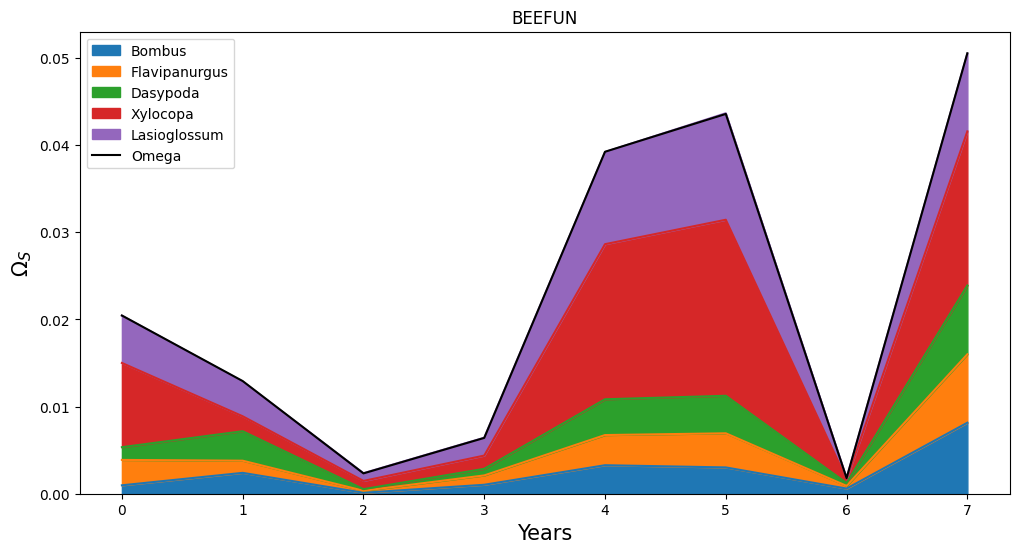

In [22]:
plot_Omega_S_regions('BEEFUN')
plot_Omega('BEEFUN')

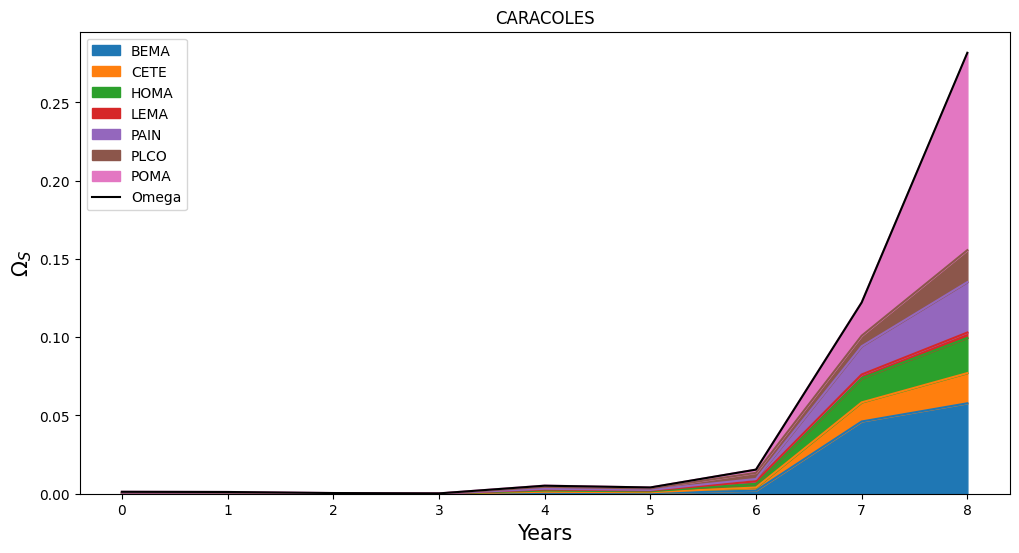

In [23]:
plot_Omega_S_regions('CARACOLES')
plot_Omega('CARACOLES')

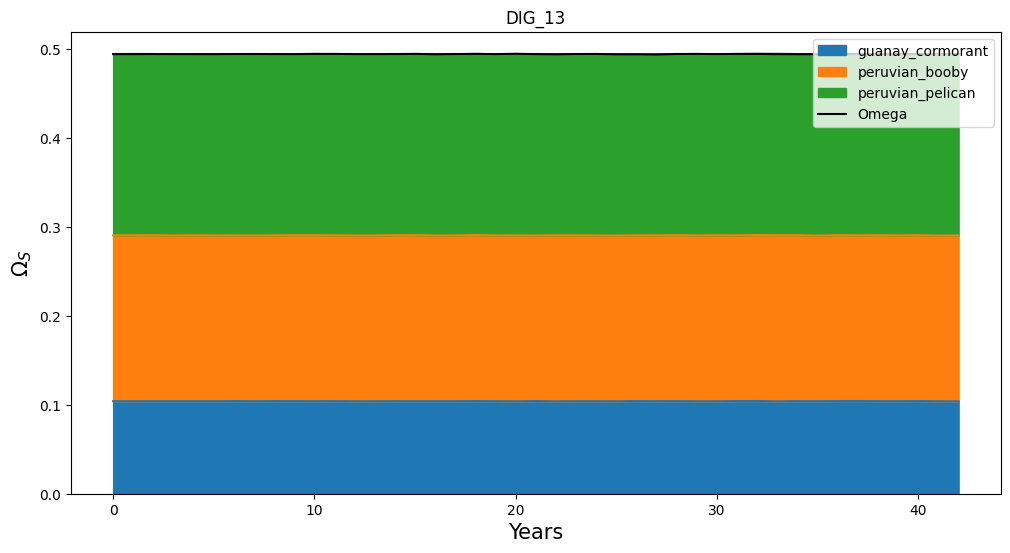

In [24]:
plot_Omega_S_regions('DIG_13')
plot_Omega('DIG_13')

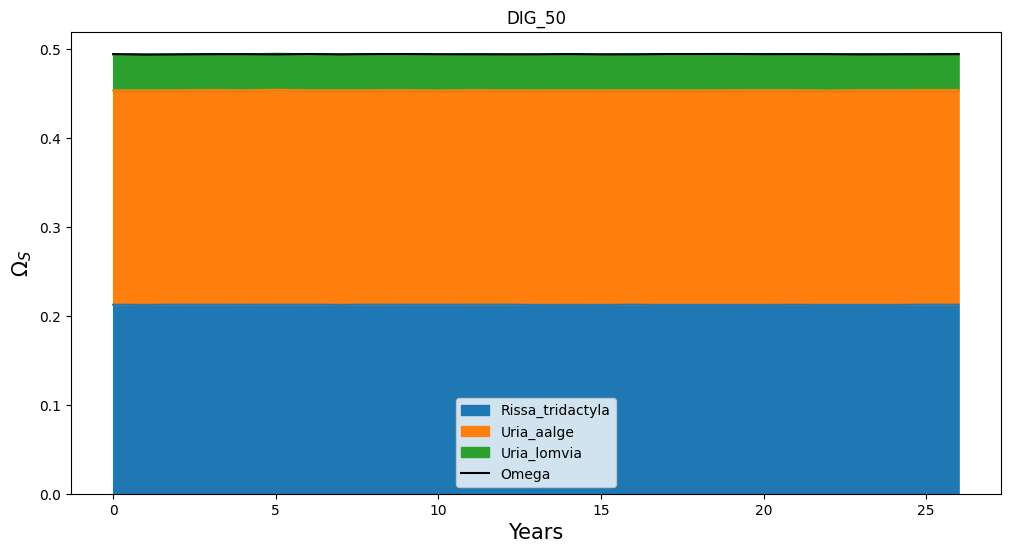

In [25]:
plot_Omega_S_regions('DIG_50')
plot_Omega('DIG_50')

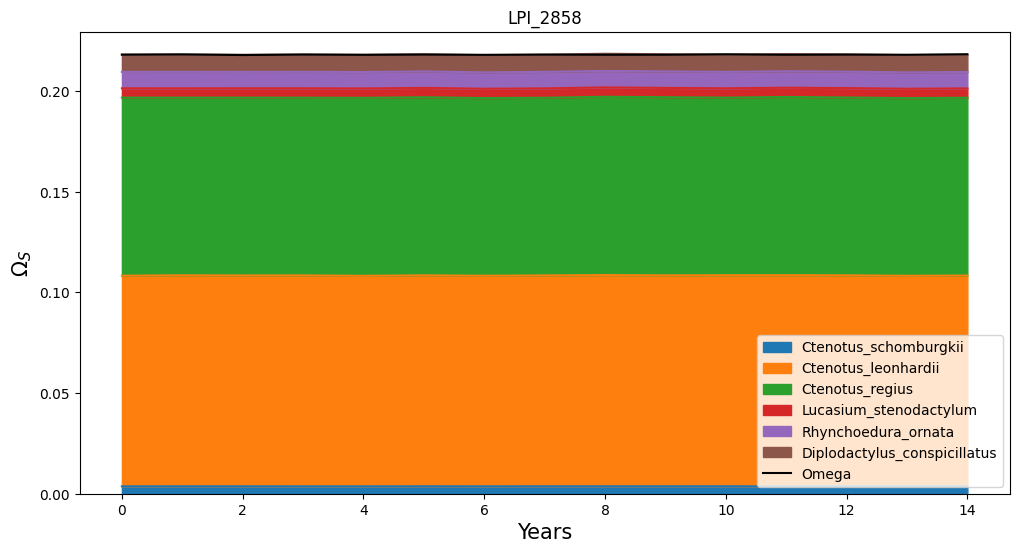

In [26]:
plot_Omega_S_regions('LPI_2858')
plot_Omega('LPI_2858')

Entropy

In [31]:
def plot_prob_ext_env(name):
    species_names = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_A.csv').to_numpy()[:,:1][:,0]
    env_range = giveP(name)

    C = calculateC(name)
    PiE = dict()
    temporal = C.shape[-1]
    for species_number, name in enumerate(species_names):
        PiE[species_number] = calculate_prob_ext(C, name,species_number)
        plt.plot(env_range, PiE[species_number], 'o',label = name)

    plt.plot(env_range, [1/len(species_names) for _ in range(temporal)],':',color = 'black', label = 'Symmetric FD')
    plt.xlabel('Environment',fontsize=15)
    plt.ylabel('$P_i^E(A)$',fontsize=15)
    plt.legend()

def giveP(name):
    P = pd.read_csv('complexity72h-2025-main/data/'+name+'/env.csv')
    P = P.drop(columns=['Unnamed: 0'], errors='ignore').to_numpy()
    return P.transpose()[0]

def shannon_diversity_index(PiE):
    return -sum([PiE[n_s]*np.log(PiE[n_s]) for n_s in range(len(PiE))])/np.log(len(PiE))


def prob_ext_env_to_J(name):
    species_names = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_A.csv').to_numpy()[:,:1][:,0]

    env_range = giveP(name)
    C = calculateC(name)
    temporal = C.shape[-1]

    J_list =[]
    PiE = dict()
    for species_number, name_s in enumerate(species_names):
        PiE[name_s] = calculate_prob_ext(C, name,species_number)
    PiE_ar = np.array([PiE[name_s] for name_s in species_names])

    for t in range(temporal):
        J_list.append( shannon_diversity_index(PiE_ar[:,t]))
        
    return J_list


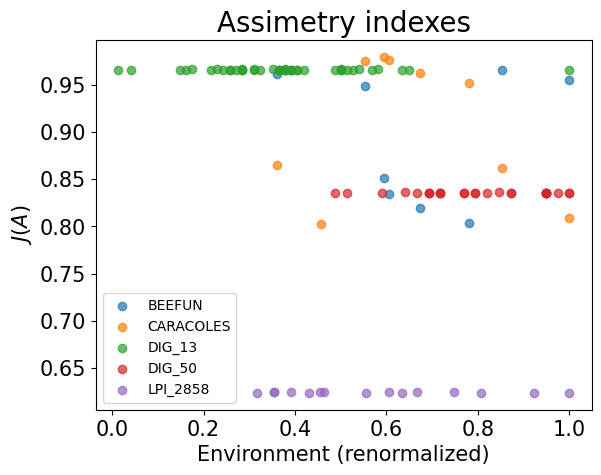

In [32]:
for name in ['BEEFUN', 'CARACOLES', 'DIG_13', 'DIG_50', 'LPI_2858']:
    env_range = giveP(name)
    J_list = prob_ext_env_to_J(name)
    plt.scatter(env_range/max(env_range),J_list ,marker =  'o', label = name, alpha = 0.7)

plt.title('Assimetry indexes',fontsize=20)
plt.xlabel('Environment (renormalized)',fontsize=15)
plt.ylabel('$J(A)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()

$\theta$

In [27]:

def species_vector_to_incenter_xitheta(C):
    temporal = C.shape[-1]
    C2 = np.zeros(C.shape)
    theta_list = []
    Xi_list = []
    for t in range(temporal):
        r_incenter, theta, Xi = incenter_inradius_isoprob_calculation(C[:,:,t])
        theta_list.append(theta)
        Xi_list.append(Xi)
    return theta_list,Xi_list


def calculate_xitheta(C):
    temporal = C.shape[-1]
    Omegas = np.zeros((temporal))
    Omegas_S = np.zeros((temporal))
    prob_ext = np.zeros((temporal))
    theta_list, Xi_list = species_vector_to_incenter_xitheta(C)
    print(theta_list[0])
    return theta_list, Xi_list 


def plot_theta(name):
    C = calculateC(name)
    print(name)
    temporal = C.shape[-1]
    theta, xi = calculate_xitheta(C)
    plt.plot(range(temporal), theta)
    plt.xlabel('Years',fontsize=15)
    plt.ylabel(r'$\theta$',fontsize=15)
    plt.title(name,fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)


BEEFUN
0.15941421714314155
CARACOLES
0.23571800263968945
DIG_13
1.5558872638581838
DIG_50
1.5328761759895233
LPI_2858
0.2592410389793425


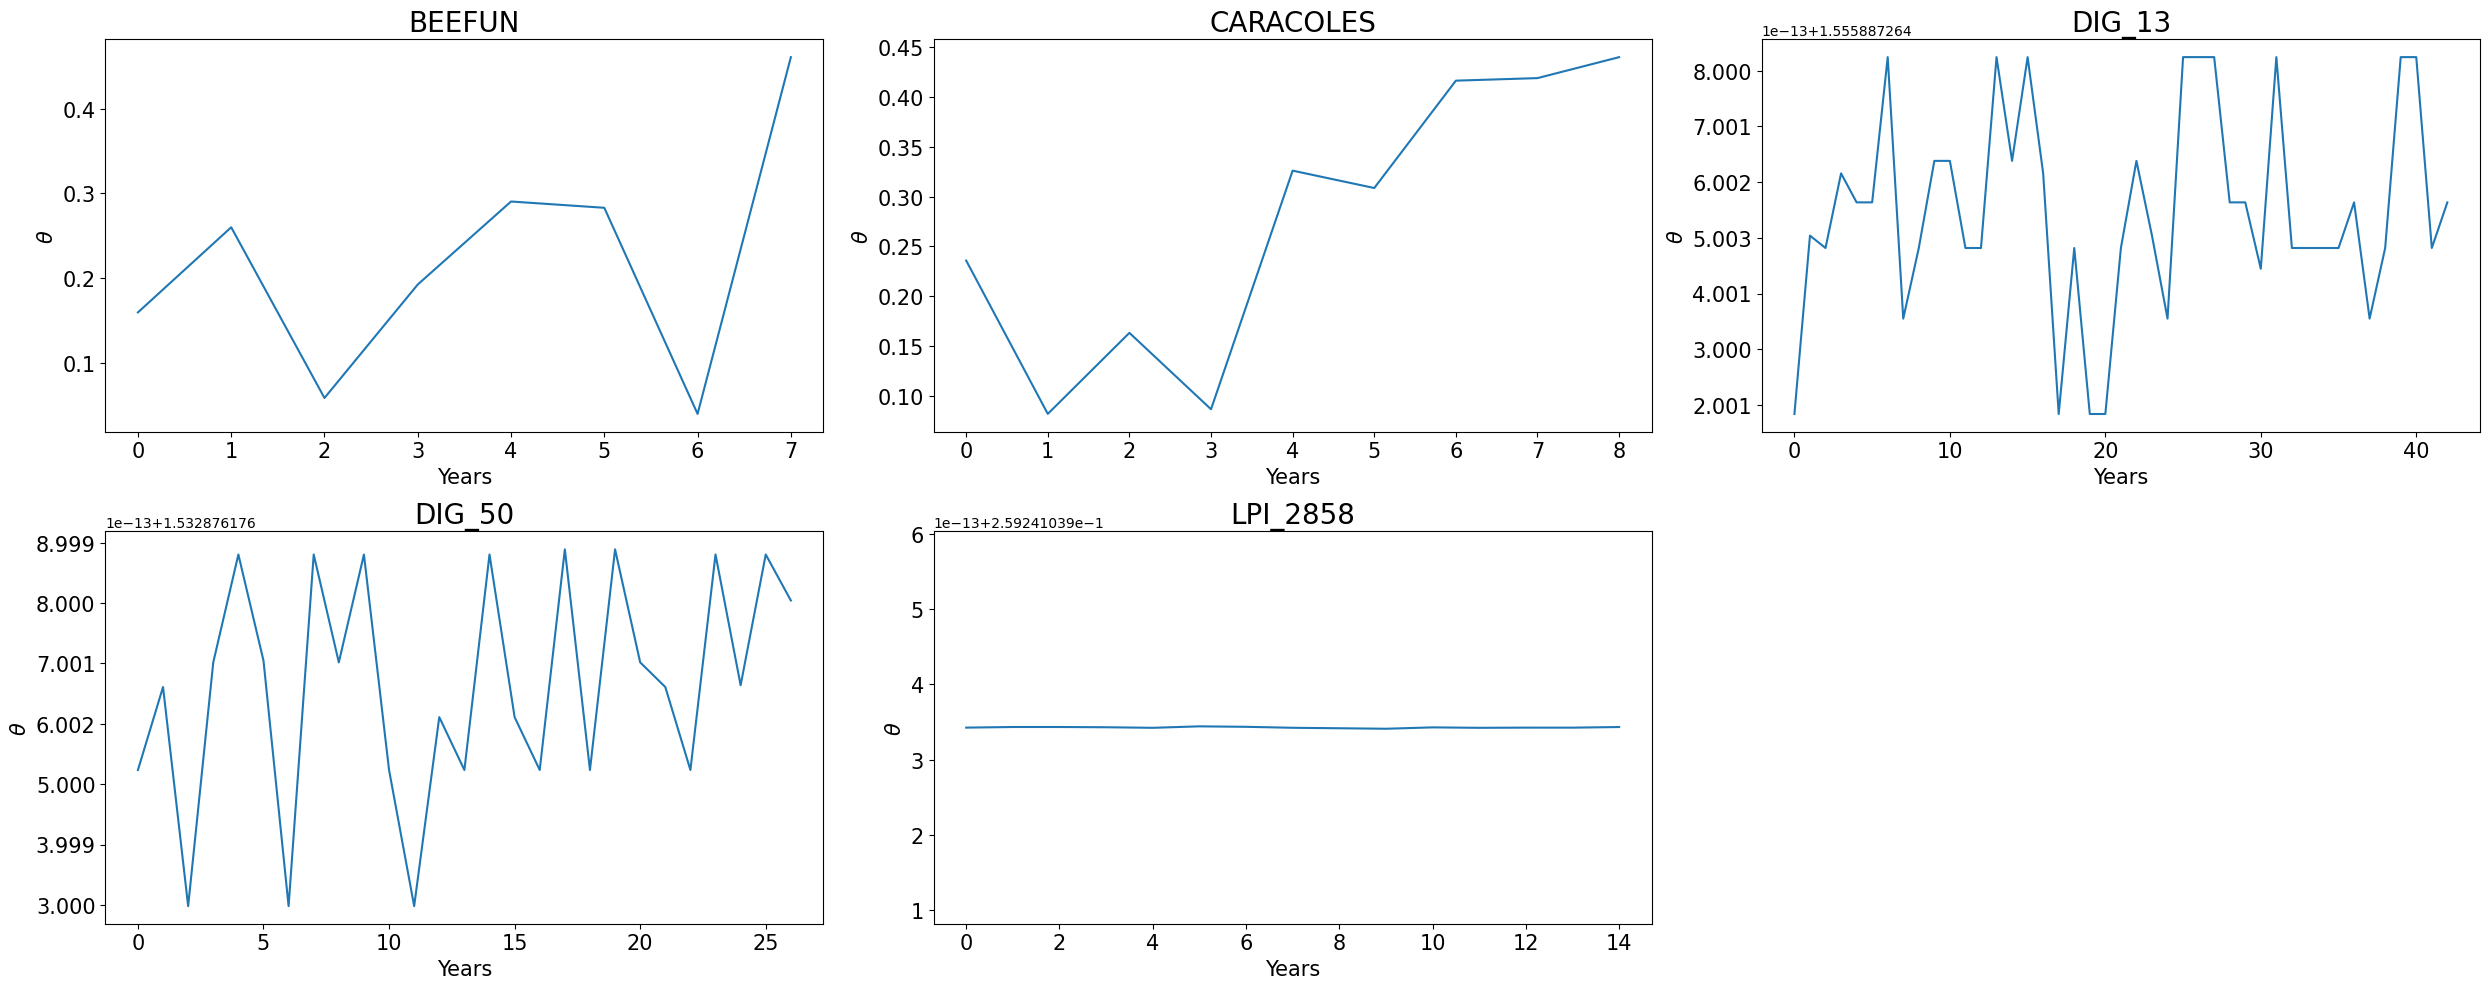

In [28]:
plt.figure(figsize=(25,10))

plt.subplot(2,3,1)
plot_theta('BEEFUN')

plt.subplot(2,3,2)
plot_theta('CARACOLES')

plt.subplot(2,3,3)
plot_theta('DIG_13')

plt.subplot(2,3,4)
plot_theta('DIG_50')

plt.subplot(2,3,5)
plot_theta('LPI_2858')

plt.tight_layout()
plt.show()

$\xi$

In [29]:
def plot_xi(name):
    C = calculateC(name)
    temporal = C.shape[-1]
    theta, xi = calculate_xitheta(C)
    plt.plot(range(temporal), xi)
    plt.xlabel('Years',fontsize=15)
    plt.ylabel(r'$\xi$',fontsize=15)
    plt.title(name,fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)


0.15941421714314155
0.23571800263968945
1.5558872638581838
1.5328761759895233
0.2592410389793425


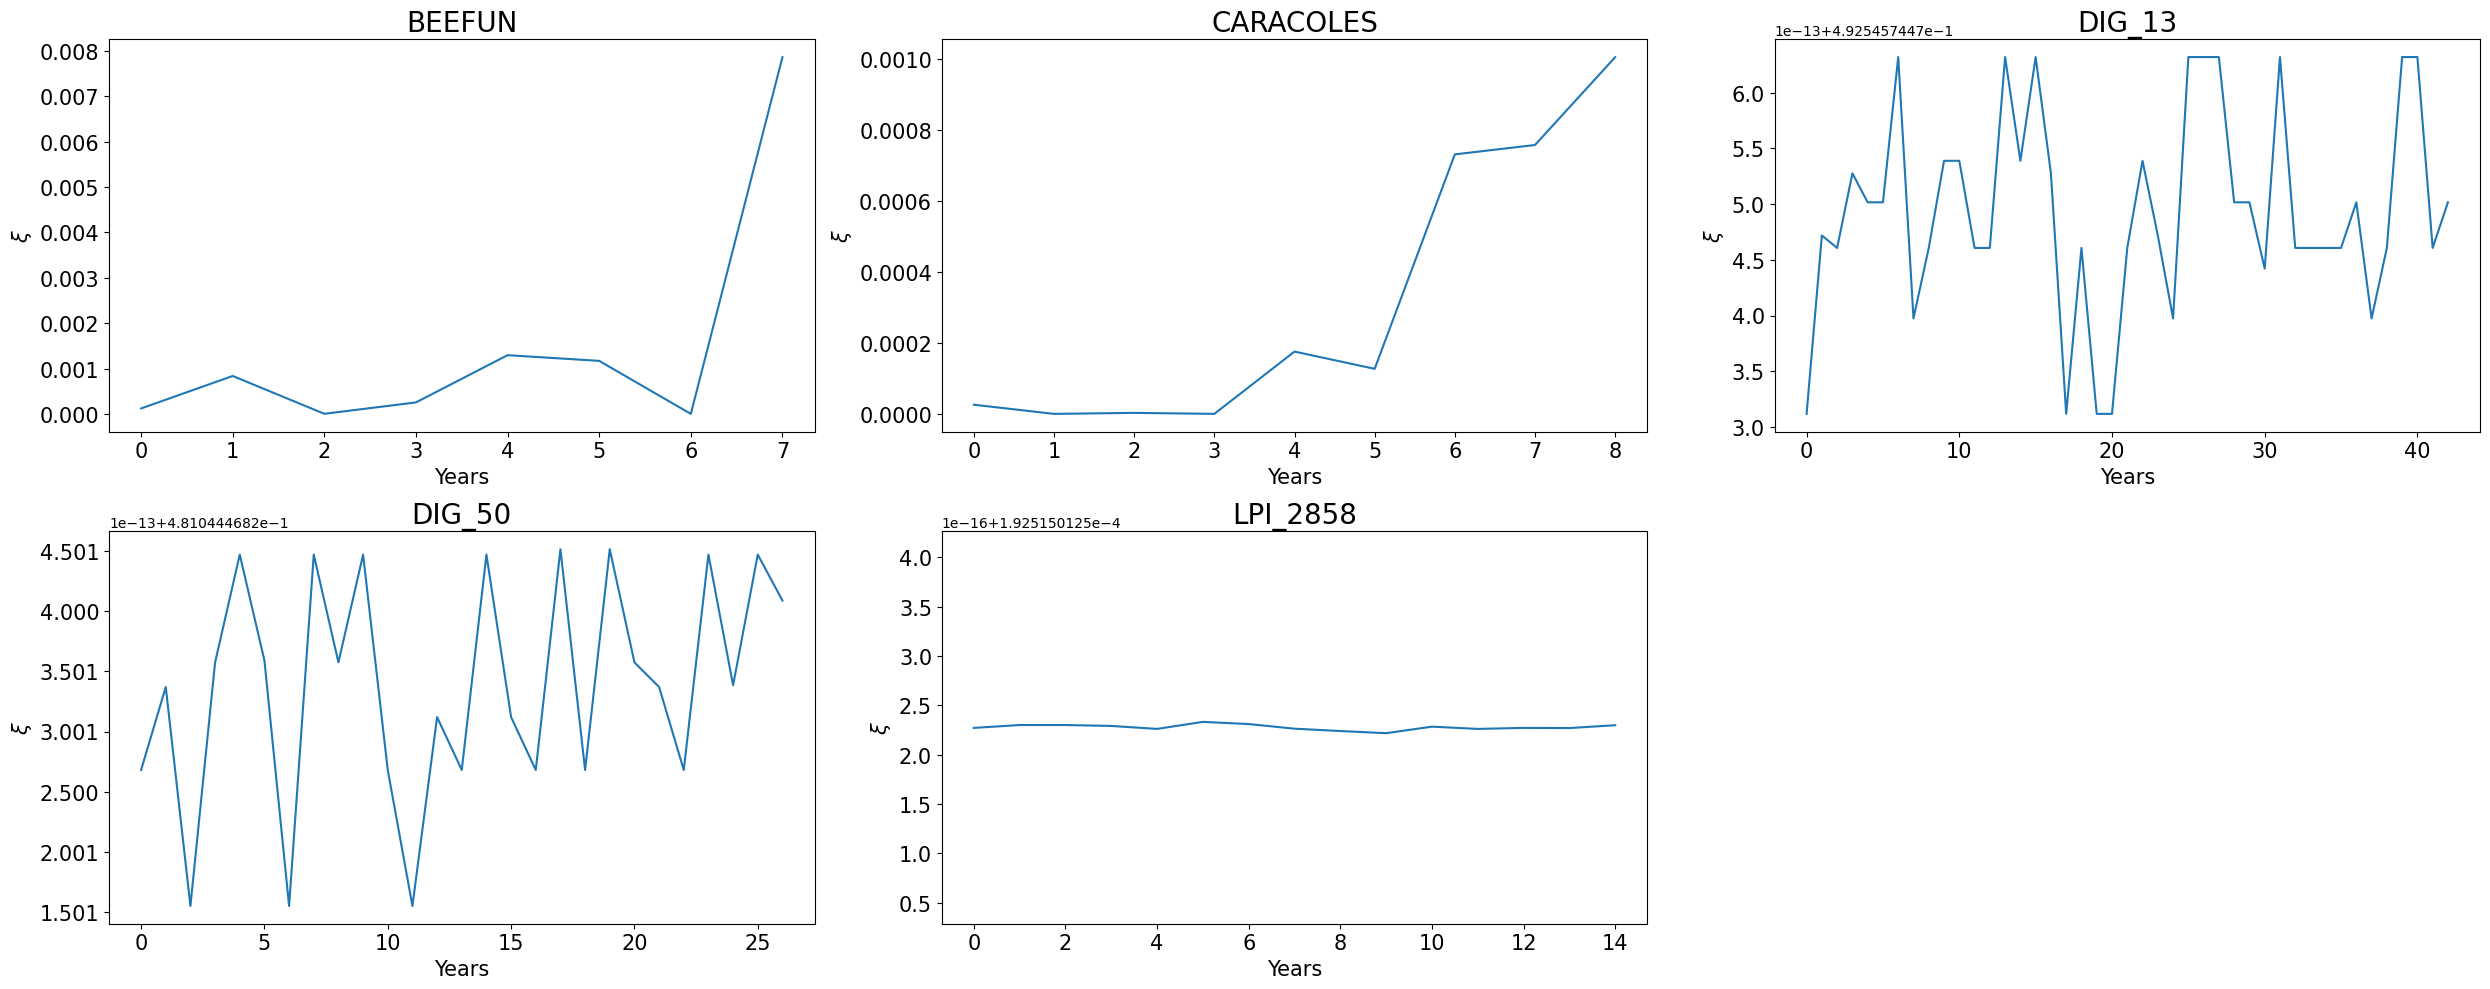

In [30]:
plt.figure(figsize=(25,10))

plt.subplot(2,3,1)
plot_xi('BEEFUN')


plt.subplot(2,3,2)
plot_xi('CARACOLES')

plt.subplot(2,3,3)
plot_xi('DIG_13')

plt.subplot(2,3,4)
plot_xi('DIG_50')

plt.subplot(2,3,5)
plot_xi('LPI_2858')

plt.tight_layout()
plt.show()

Evaluation of extinction subdomain with the r vector

In [33]:
r = list(pd.read_csv('complexity72h-2025-main/data/LPI_2858/intrinsic_model.csv')['x'])

In [35]:

def species_vector_to_incenter_r(C, name, species_number):
    temporal = C.shape[-1]
    C2 = np.zeros(C.shape)
    for t in range(temporal):
        r_incenter = np.array(pd.read_csv('complexity72h-2025-main/data/'+name+'/intrinsic_model.csv')['x'])#, theta, Xi = incenter_inradius_isoprob_calculation(C[:,:,t])
        vectors = np.hsplit(C[:,:,t], C[:,:,t].shape[1])    
        vectors[species_number] = r_incenter
        C2[:,:,t] = np.column_stack(vectors)
    return C2 


def calculate_Omega_S_r(C, name, species_number):
    temporal = C.shape[-1]
    Omegas = np.zeros((temporal))
    Omegas_S = np.zeros((temporal))
    prob_ext = np.zeros((temporal))
    C2 = species_vector_to_incenter_r(C, name,species_number)
    for t in range(temporal):
        Omegas_S[t] = np.mean(omega_bootstrap(C2[:,:,t], replicates=1000, samples_per_replicate=10000, seed=42))

    return Omegas_S 

def plot_Omega_S_regions_r(name):
    species_names = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_A.csv').to_numpy()[:,:1][:,0]
    C = calculateC(name)
    PiE = dict()
    temporal = C.shape[-1]
    for species_number, name_s in enumerate(species_names):
        PiE[species_number] = calculate_Omega_S_r(C, name,species_number)

    df = pd.DataFrame({name_s: PiE[i] for i, name_s in enumerate(species_names)})
    ax = df.plot.area(stacked=True, figsize=(12, 6))
    plt.title(name)
    plt.xlabel('Years', fontsize=15)
    plt.ylabel('$\Omega_S$', fontsize=15)
    plt.legend()


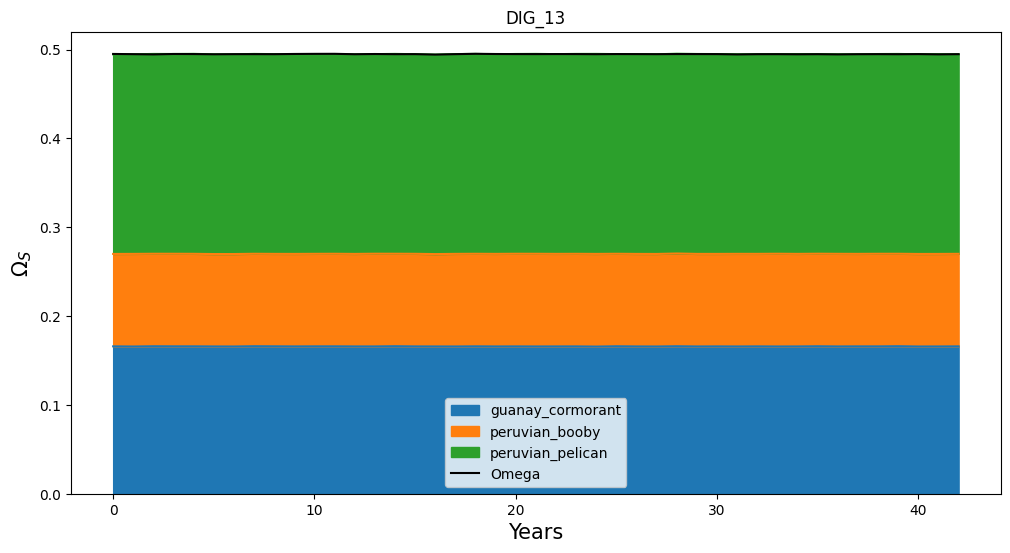

In [38]:
plot_Omega_S_regions_r('DIG_13')
plot_Omega('DIG_13')

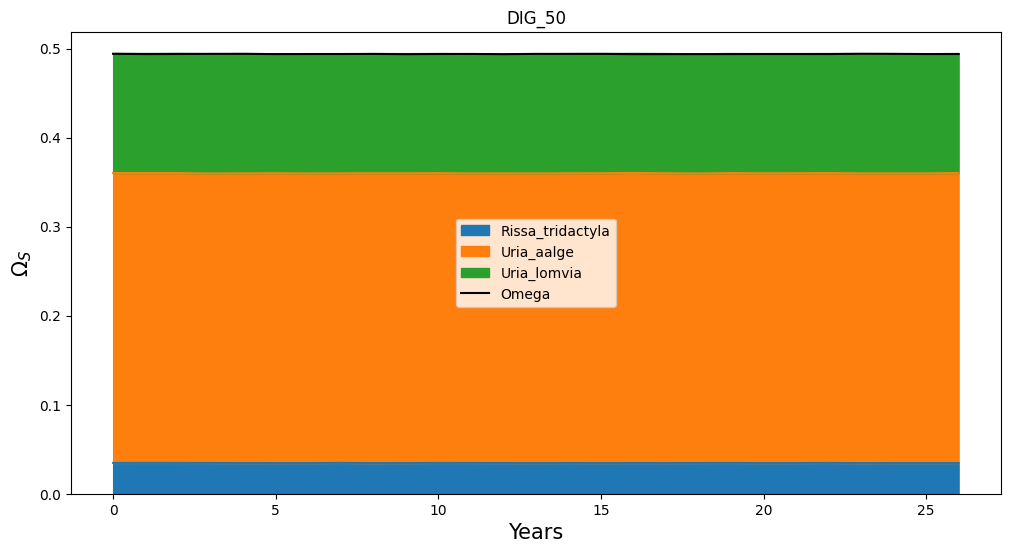

In [39]:
plot_Omega_S_regions_r('DIG_50')
plot_Omega('DIG_50')

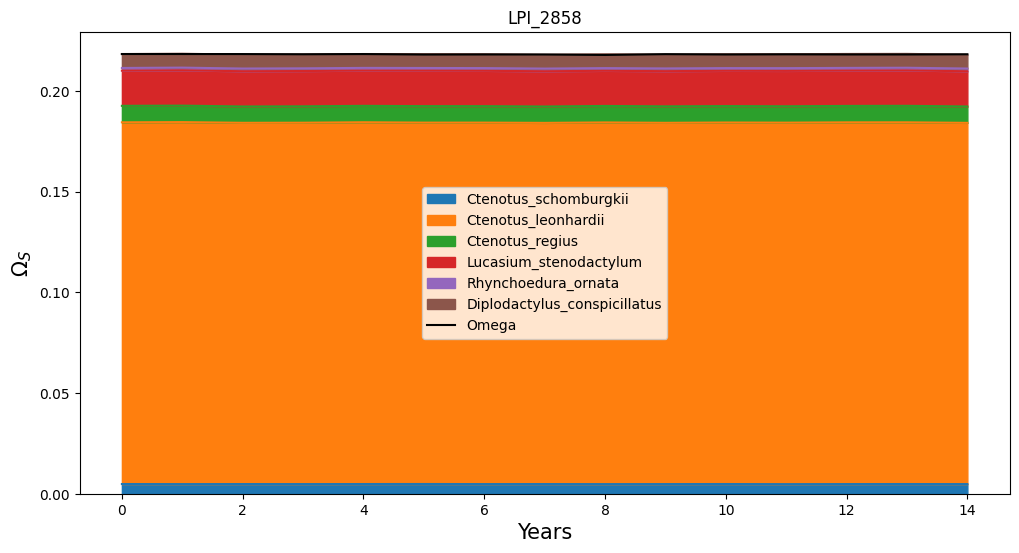

In [37]:
plot_Omega_S_regions_r('LPI_2858')
plot_Omega('LPI_2858')